# Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import os

from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score

# GCN
## Single GCN for Autoencoder

In [3]:
class GCN_layer(nn.Module):
    """
    Relation GCN layer. 
    """

    def __init__(self, in_features, out_features, edge_dim = 3, aggregate='sum', dropout = 0.0, use_relu = True, bias = False):
        '''
        parameters:
        in/out_features: embedding dimension of input/output
        edge_dim: dim of edge type
        aggregate: Type of aggregation to be used for pooling
        '''
        super(GCN_layer, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.edge_dim = edge_dim
        self.dropout = dropout
        self.aggregate = aggregate
        
        if use_relu:
            self.act = nn.ReLU()
        else:
            self.act = None

        self.weight = nn.Parameter(torch.FloatTensor(
            self.edge_dim, self.in_features, self.out_features)) 
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(
                self.edge_dim, self.out_features)) 
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0.0)

    def forward(self, x, adj):
        '''
        parameters:
        x: (batch, N, NODE_FEATURES)
        adj: (batch, EDGE_FEATURES, N, N)
        
        returns:
        embedding with shape (batch, N, d)
        '''
        
        x = F.dropout(x, p=self.dropout, training=self.training)  # (batch, N, d)

        batch_size = x.size(0)

        #form layer output
        support = torch.einsum('bnd, edh-> benh', x, self.weight)
        output = torch.einsum('...ij, ...jh-> ...ih', adj, support)  # (batch, EDGE_FEATURES, N, d)
        
        if self.bias is not None:
            output += self.bias
            
        if self.act is not None:
            output = self.act(output)  # (batch, EDGE_FEATURES, N, d)
        
        output = output.view(batch_size, self.edge_dim, x.size( 
            1), self.out_features)  # (batch, EDGE_FEATURES, N, d) 
    
        #Aggregates over each of the edge dimensions
        if self.aggregate == 'sum':
            # sum pooling #(batch, N, d)
            node_embedding = torch.sum(output, dim=1, keepdim=False)
        elif self.aggregate == 'max':
            # max pooling  #(batch, N, d)
            node_embedding = torch.max(output, dim=1, keepdim=False)
        elif self.aggregate == 'mean':
            # mean pooling #(batch, N, d)
            node_embedding = torch.mean(output, dim=1, keepdim=False)
        elif self.aggregate == 'none':
            node_embedding = output
        else:
            print('GCN aggregate error!')

        return node_embedding

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [4]:
def Linear(in_features, out_features, bias=True):

    m = nn.Linear(in_features, out_features, bias)
    nn.init.xavier_uniform_(m.weight)
    if bias:
        nn.init.constant_(m.bias, 0.0)
    return m

# Autoencoder

In [6]:
#Autoencoder with GCN layers
class Autoencoder(nn.Module):
    def __init__(self, nfeat, nhid, a_nout, x_nout, edge_dim = 3, num_layers = 5, dropout = 0.0, gcn_bias = False):
        '''
        parameters:
        n_feat: number of node features
        n_hid: array of embedding sizes for each hidden layer
        n_out: embedding size for last layer
        '''
        super(Autoencoder, self).__init__()

        self.nhid = nhid
        self.nfeat = nfeat
        self.x_nout = x_nout
        self.a_nout = a_nout 
        self.dropout = dropout
        
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        
        self.emb = Linear(nfeat, nfeat, bias = False) 
        
        self.gc1 = GCN_layer(
            nfeat, nhid[0], edge_dim = self.edge_dim, aggregate='sum', use_relu=True, dropout=self.dropout, bias = gcn_bias)
        
        in_dim = [self.a_nout, self.gc1.out_features]
        self.lnorm1 = nn.LayerNorm(in_dim)
        
        self.gc2 = nn.ModuleList([GCN_layer(nhid[i], nhid[i+1], edge_dim=self.edge_dim, aggregate='sum',
                                                           use_relu=True, dropout=self.dropout, bias= gcn_bias)
                                  for i in range(self.num_layers-2)])
        
        in_dim = [self.a_nout, self.gc2[-1].out_features]
        self.lnorm2 = nn.LayerNorm(in_dim)
        
        self.gc3 = GCN_layer(
            nhid[-1], self.x_nout, edge_dim=self.edge_dim, aggregate='sum', use_relu=False, dropout=self.dropout, bias= gcn_bias)
        
        self.gc4 = GCN_layer(
            nhid[-1], self.a_nout, edge_dim=self.edge_dim, aggregate='none', use_relu=False, dropout=self.dropout, bias= gcn_bias)
        
        self.A_activation = nn.Sigmoid()
        self.X_activation = nn.ReLU()
        
    def forward(self, x, adj):
        '''
        x: (batch, N, d)
        adj: (batch, E, N, N)
        
        return X, Adj
        '''
        
        # embedding layer
        x = self.emb(x)
      
        # first GCN layer
        x = self.gc1(x, adj)
        x = self.lnorm1(x)
    
        # hidden GCN layer(s)
        for i in range(self.num_layers-2):
            x = self.gc2[i](x, adj)  # (#node, #class)
        
        # normalize layer
        x = self.lnorm2(x)

        # gcn layer for X
        xt = self.gc3(x, adj)  # (batch, N, d)
        xt = self.X_activation(xt)
        
        # gcn Layer for A
        at = self.gc4(x, adj)  # (batch, E, N, D)
        at = self.A_activation(at) 
                
        #Reconstructs the feature matrix and adjacency matrix
        return xt, at

# Train and Validation Functions

In [7]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    
    total_loss = 0.0
    
    for X, adj in train_loader:
        # reset gradients
        optimizer.zero_grad()
        
        # Pass X and Adj Matrices to device
        X = X.to(device)
        adj = adj.to(device)

        # Get X_hat, A_hat
        X_pred, A_pred = model(X, adj)
        loss = criterion(X_pred, A_pred, X, adj)
        
        total_loss += X.shape[0] * loss.item()
        
        loss.backward()
        optimizer.step()
        
    return model, optimizer, total_loss / len(train_loader.dataset)

def validate(model, criterion, optimizer, valid_loader, device):
    model.eval()
    
    total_loss = 0.0
    
    for X, adj in valid_loader:
        X = X.to(device)
        adj = adj.to(device)
        
        X_pred, A_pred = model(X, adj)
        loss = criterion(X_pred, A_pred, X, adj)
       
        total_loss += X.shape[0] * loss.item()
       
    return model, total_loss / len(valid_loader.dataset)

def train_epoch(model, criterion, optimizer, train_loader, valid_loader, device):
    model, optimizer, train_loss = train(model, criterion, optimizer, train_loader, device)
    
    model, validate_loss = validate(model, criterion, optimizer, valid_loader, device)
        
    return model, train_loss, validate_loss

# Utils

In [199]:
class myDataset(Dataset):
    def __init__(self,node_features,adj_features):
        
        self.node_features = node_features
        self.n_samples = self.node_features.shape[0]
        self.max_size = self.node_features.shape[1]
        self.node_dim = self.node_features.shape[2]
        
        self.adj_features = adj_features
        self.edge_dim = self.adj_features.shape[1]
        
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        X = self.node_features[idx]
        adj = self.adj_features[idx]

        return torch.Tensor(X), torch.Tensor(adj)
    
def read_data(folder,name):
    path = os.getcwd() + '/'  + folder + '/'
    node_features = np.load(path + name + '_node_features.npy')
    adj_features = np.load(path + name +  '_adj_features.npy')
    mol_sizes = np.load(path + name + '_sizes.npy')

    f = open(path + '_config.txt', 'r')
    data_config = eval(f.read())
    f.close()

    return node_features, adj_features, mol_sizes, data_config 

def find_distribution(data_loader, model, criterion, device):
    #Stores the probabilities of each graph
    losses = []
    for X, adj in data_loader:
        
        #Reads in the batch adjacency tensors and node feature matrices
        adj = adj.to(device)
        X = X.to(device)
        
        X_pred, A_pred = model(X, adj)
        loss = criterion(X_pred, A_pred, X, adj)
        
        losses.append(loss.item())
        
    return np.array(losses)

def custom_loss(X_pred, A_pred, X, A, alpha = 0.5):
    loss = (1.0 - alpha) * torch.norm(A - A_pred) + alpha * torch.norm(X - X_pred)
    return loss

# Prep Data
### $N_{train} = 1000$ | $N_{val} = 250$ | $N_{test} = 250$ | $N_{anomaly} = 250$

In [200]:
#Generate the samples
!python data_process.py Data 1000 250 250 250

Name: 
Type: Graph
Number of nodes: 7852
Number of edges: 8261
Average degree:   2.1042
Max dependency: 18
Training dataset node stats: mean - 18.36 std - 4.68, [2.00,20.00]
Training dataset degree stats: mean - 1.87 std - 0.22, [1.00,4.20]
Training dataset triangle stats: mean - 0.09 std - 0.56, [0.00,7.00]
Successfully generated 1000 graphs for training
Successfully generated 250 graphs for validation
Successfully generated 250 graphs for testing

Anomaly set node stats: mean - 18.00 std - 6.00
Anomaly set degree stats: mean - 13.27 std - 0.44
Anomaly set triangle stats: mean - 495.42 std - 29.63
Successfully generated 250 Anomalous graphs


# Load Data

In [214]:
#Reads in the data 
train_X, train_adj, train_sizes, data_config  = read_data('test_data','train')
valid_X, valid_adj, valid_sizes, data_config = read_data('test_data','valid')
test_X, test_adj, test_sizes, data_config = read_data('test_data','test')

train_set = myDataset(train_X, train_adj)
train_loader = DataLoader(dataset = train_set, batch_size = 64, shuffle=True)
 
valid_set = myDataset(valid_X,valid_adj)
valid_loader = DataLoader(dataset = valid_set, batch_size = 64, shuffle=True)

test_set = myDataset(test_X,test_adj)
test_loader = DataLoader(dataset = test_set, batch_size = 1, shuffle=True)

node_dim = train_X.shape[2]
edge_dim = train_adj.shape[1]

# Train Model

In [215]:
nhid = [128, 128, 64, 32]
model = Autoencoder(nfeat = node_dim, nhid=nhid, a_nout = train_adj.shape[2], x_nout = 512, edge_dim = edge_dim, num_layers = 5)

criterion = custom_loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay = 0.1)

#Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_epochs = 10

train_hist = np.zeros(n_epochs)
validate_hist = np.zeros(n_epochs)

for epoch in range(n_epochs):
    model, train_loss, validate_loss = train_epoch(model, criterion, optimizer, train_loader, valid_loader, device)
    
    print("Epoch:", epoch + 1, "\ttrain-loss:", train_loss, "\tvalidate-loss:", validate_loss)
    
    train_hist[epoch], validate_hist[epoch] = train_loss, validate_loss

Epoch: 1 	train-loss: 334.11518920898436 	validate-loss: 326.9080964355469
Epoch: 2 	train-loss: 325.74293188476565 	validate-loss: 322.61360595703127
Epoch: 3 	train-loss: 322.83242041015626 	validate-loss: 321.93755859375
Epoch: 4 	train-loss: 322.54049340820313 	validate-loss: 321.8271486816406
Epoch: 5 	train-loss: 322.4862099609375 	validate-loss: 321.54093798828126
Epoch: 6 	train-loss: 322.4499560546875 	validate-loss: 321.4853044433594
Epoch: 7 	train-loss: 322.407349609375 	validate-loss: 321.39077026367187
Epoch: 8 	train-loss: 322.3320891113281 	validate-loss: 321.3705654296875
Epoch: 9 	train-loss: 322.3328161621094 	validate-loss: 321.3864306640625
Epoch: 10 	train-loss: 322.34082421875 	validate-loss: 321.38582470703125


# Convergence Plots

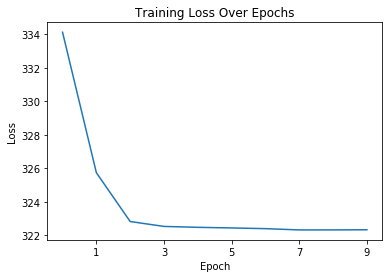

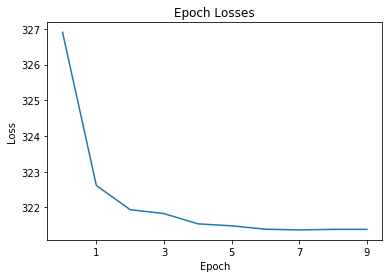

In [218]:
#Creates a plot of the losses as a function of the epoch
plt.plot(train_hist)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

#plt.savefig('epoch_losses.png')
plt.xticks(np.arange(1, len(train_hist) + 1, step = 2) )
plt.show()

#Creates a plot of the losses as a function of the epoch
plt.plot(validate_hist)
plt.title("Epoch Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")

#plt.savefig('epoch_losses.png')
plt.xticks(np.arange(1, len(validate_hist) + 1, step = 2) )
plt.show()

# Metrics

Best Threshold=40.383808:
AUC score: 0.257
f1 score: 0.148
Precision@50: 0.500
Recall@50: 0.100
Precision@100: 0.284
Recall@100: 0.100
Precision: 0.284
Recall: 0.100


<Figure size 432x288 with 0 Axes>

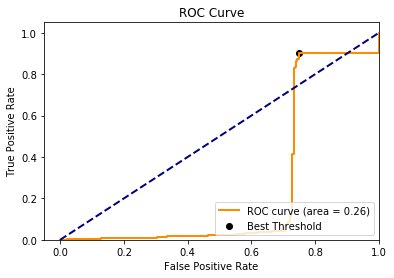

In [220]:
model.eval()

#Loads anomaly data
anom_X,anom_adj,anom_sizes,data_config = read_data('test_data','extra')
anom_set = myDataset(anom_X,anom_adj)
anom_loader = DataLoader(dataset=anom_set,batch_size=1,shuffle=True)
        
#Calculates the log-prob distribution for each set
train_probs = find_distribution(train_loader,model,criterion,device)
test_probs = find_distribution(test_loader,model,criterion,device)
anom_probs = find_distribution(anom_loader,model,criterion,device)

#Concatenates
total_probs = np.concatenate((test_probs,anom_probs))

#Plots histograms for each set with a kde plot overlay
#sns.histplot(data=train_probs,color='b',stat="density",label='Train', kde=True)
sns.histplot(data=test_probs,color='g', stat="probability", label='Test', kde=True , binwidth = 0.1)
sns.histplot(data=anom_probs,color='r', stat="probability", label='Anomalies', kde=True, binwidth = 0.1)
plt.legend()
plt.title("Autoencoder Loss Distribution")
plt.xlabel('Custom Loss')
plt.savefig('autoencoder_loss_distribution.png')
plt.clf()

# Forms ROC curve and calculates AUC score
# Takes only the testing data and anomaly data (excludes training data)
Y_probs = total_probs
    
# Initializes class label 1 for all graphs from the test set and 0 for all graphs from the anomaly dataset
Y_true = np.zeros(Y_probs.shape[0])
Y_true[test_probs.shape[0]:] = 1
    
#Calculates the ROC and AUC statistics
fpr, tpr, thresholds = roc_curve(Y_true, Y_probs)
roc_auc = auc(fpr,tpr)

#Finds the optimal threshold
geometric_means = np.sqrt(tpr * (1 - fpr))
best_threshold_index = np.argmax(geometric_means)
best_threshold = thresholds[best_threshold_index]
print('Best Threshold=%f:' % best_threshold)

#Plots ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], marker='o', color='black', label='Best Threshold')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('autoencoder_ROC_curve.png')

Y_pred = np.zeros(Y_true.shape[0])
Y_pred[Y_probs < best_threshold] = 1
f1 = f1_score(Y_true,Y_pred)

print('AUC score: %.3f' % roc_auc)
print('f1 score: %.3f' % f1)

results = []
for i in range(Y_probs.shape[0]):
    results.append((Y_probs[i],Y_true[i]))

results.sort(key = lambda x: x[0])

n_anomalies = anom_probs.shape[0]
    
for k in [50, 100]:
    n_detected = sum((pred < best_threshold) for (pred, __) in results[:k])
    n_correct = sum( (truth == 1 and pred < best_threshold)  for (pred,truth) in results[:k])
    k_precision = 0
    
    if n_detected != 0:
        k_precision = float(n_correct) / n_detected
        k_recall = float(n_correct) / n_anomalies
        print('Precision@{:.0f}: {:.3f}'.format(k,k_precision))
        print('Recall@{:.0f}: {:.3f}'.format(k,k_recall))

detections = Y_true[Y_pred == 1]
n_correct = detections[detections == 1].shape[0]
precision = 0
if detections.shape[0] != 0:
    precision = float(n_correct) / detections.shape[0]

recall = float(n_correct) / n_anomalies
print('Precision:', '%.3f' % precision)
print('Recall:','%.3f' % recall)